In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from collections import defaultdict


In [3]:
# Load JSON file
with open('scientific-papers.json', 'r') as f:
    data = json.loads(f.read())
    #data = json.load(f)


In [4]:
# Extract necessary information and create a DataFrame
papers_data = []
for paper in data:
    abstract = paper.get('abstractText', '')
    if abstract is None:
      continue
    co_authors = [f"{author['person']['firstname']} {author['person']['lastname']}" for author in paper.get('referenceAuthors', [])]
    papers_data.append({'abstract': abstract, 'co_authors': co_authors})

papers = pd.DataFrame(papers_data)

# Inspect the DataFrame
print(papers.head())
print(papers.columns)
print(papers.shape)

                                            abstract  \
0  The perception of depth in images and video se...   
1  Network virtualization is recognized as an ena...   
2  Tumorpatienten sind im Verlauf ihrer Erkrankun...   
3  Evenness measurement on polished support plate...   
4  Innovationsnetzwerke sind primär durch Koopera...   

                                          co_authors  
0  [P. Lebreton, A. Raake, Marcus Barkowsky, P. L...  
1  [M. Duelli, D. Schlosser, J. Botero, X. Hessel...  
2         [A. Eustachi, W. Dörfler, Dieter Melchart]  
3       [Engelbert Hofbauer, K. Röttger, R. Kellner]  
4                         [M. Reiss, Oliver Neumann]  
Index(['abstract', 'co_authors'], dtype='object')
(1500, 2)


In [5]:
!pip install sentence_transformers


In [6]:
from sentence_transformers import SentenceTransformer

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the abstracts
papers['embedding'] = papers['abstract'].apply(lambda x: model.encode(x))



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Check the shape of a sample of embeddings to ensure consistency
embedding_shapes = papers['embedding'].apply(lambda x: x.shape)
print(embedding_shapes.value_counts())

# Verify if all embeddings have the same shape
assert embedding_shapes.nunique() == 1, "Inconsistent embedding shapes found!"


embedding
(384,)    1500
Name: count, dtype: int64


In [8]:
# Stack embeddings into a 2D array
embeddings = np.vstack(papers['embedding'].values)

# Verify the shape of the stacked embeddings
print(f"Shape of stacked embeddings: {embeddings.shape}")


Shape of stacked embeddings: (1500, 384)


In [9]:
from sklearn.preprocessing import normalize

# Normalize embeddings
normalized_embeddings = normalize(embeddings)

# Verify the shape after normalization
print(f"Shape of normalized embeddings: {normalized_embeddings.shape}")


Shape of normalized embeddings: (1500, 384)


In [10]:
!pip install umap-learn

In [11]:
import umap

 # Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.3, metric='cosine')
umap_embeddings = umap_reducer.fit_transform(normalized_embeddings)



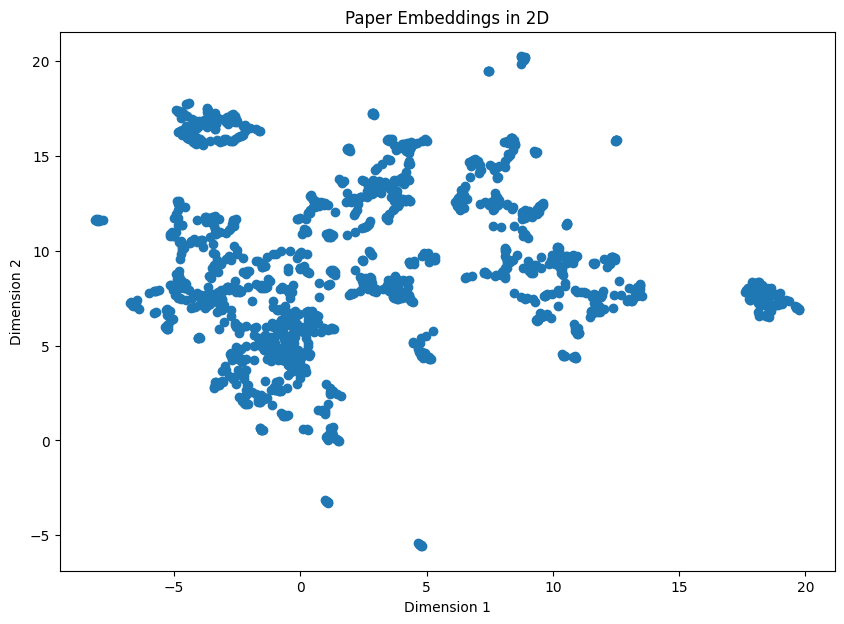

In [14]:
import matplotlib.pyplot as plt
# Plot the 2D plane
plt.figure(figsize=(10, 7))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.title("Paper Embeddings in 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distances
distances = euclidean_distances(normalized_embeddings)


In [ ]:
from collections import defaultdict

# Create a dictionary to store the embeddings of papers by each author
author_embeddings = defaultdict(list)

for index, row in papers.iterrows():
    for author in row['co_authors']:
        author_embeddings[author].append(row['embedding'])

# Compute the mean embedding for each author
author_mean_embeddings = {author: np.mean(embeds, axis=0) for author, embeds in author_embeddings.items()}

# Compute distances between authors based on their mean embeddings
author_names = list(author_mean_embeddings.keys())
author_distance_matrix = euclidean_distances([author_mean_embeddings[author] for author in author_names])


In [ ]:
# Find the closest authors for each author, excluding co-authors
author_recommendations = defaultdict(list)

for i, author in enumerate(author_names):
    distances = list(enumerate(author_distance_matrix[i]))
    distances = sorted(distances, key=lambda x: x[1])

    # Exclude self and co-authors
    co_authors = set(papers[papers['co_authors'].apply(lambda x: author in x)]['co_authors'].sum())
    closest_authors = [author_names[idx] for idx, dist in distances if author_names[idx] not in co_authors and author_names[idx] != author]

    # Get top 5 closest authors
    author_recommendations[author] = closest_authors[:5]

print(author_recommendations)


defaultdict(<class 'list'>, {'P. Lebreton': ['M. Urvoy', 'K. Wang', 'R. Cousseau', 'W. Chen', 'J. Fournier'], 'A. Raake': ['M. Urvoy', 'K. Wang', 'R. Cousseau', 'W. Chen', 'J. Fournier'], 'Marcus Barkowsky': ['Mouzhi Ge', 'None et al.', 'Diane Ahrens', 'Robert Hable', 'Michael Scholz'], 'P. Le Callet': ['P. Callet', 'B. Eskofier', 'A. Kaup', 'J. Bialkowski', 'I. Ananth'], 'M. Duelli': ['M. Beck', 'C. Linnhoff-Popien', 'F. Kokot', 'A. Paler', 'Andreas Berl'], 'D. Schlosser': ['M. Beck', 'C. Linnhoff-Popien', 'F. Kokot', 'A. Paler', 'Andreas Berl'], 'J. Botero': ['F. Kokot', 'A. Paler', 'Andreas Berl', 'H. Hlavacs', 'A. Galis'], 'X. Hesselbach': ['C. Linnhoff-Popien', 'F. Kokot', 'A. Paler', 'Andreas Berl', 'H. Hlavacs'], 'Andreas Fischer': ['H. Hlavacs', 'Mouzhi Ge', 'Martin Schramm', 'Michael Heigl', 'B. Buhnova'], 'H. Meer': ['Mouzhi Ge', 'Martin Schramm', 'B. Buhnova', 'T. Pitner', 'Michael Heigl'], 'A. Eustachi': ['Mareike Hechinger', 'J. Dai', 'Andreas Gegenfurtner', 'A. Kobleder',

In [ ]:
from sklearn.cluster import KMeans

# Perform k-means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_embeddings)

# Add cluster labels to DataFrame
papers['cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
!pip install keybert

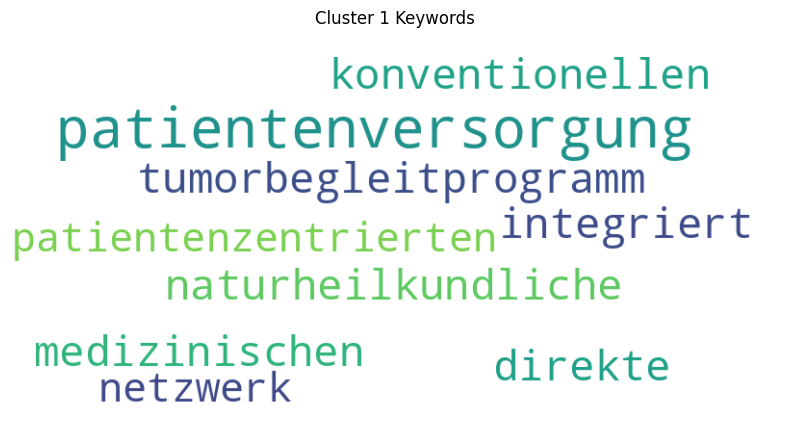

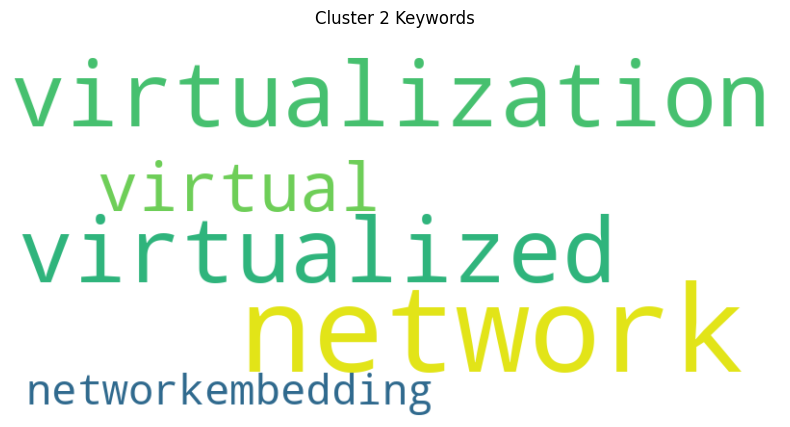

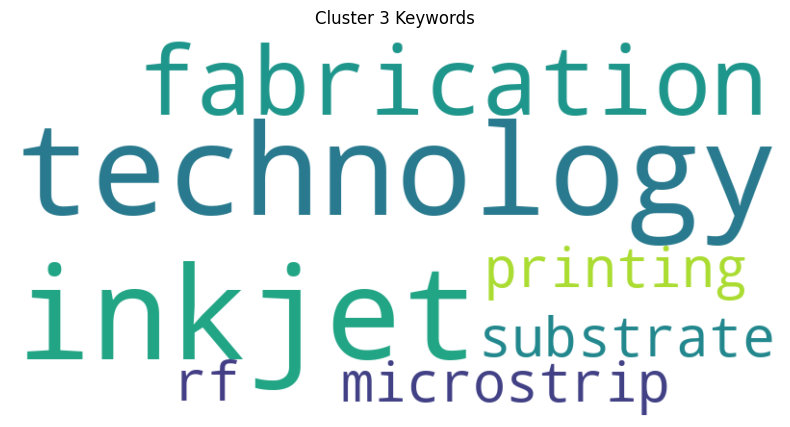

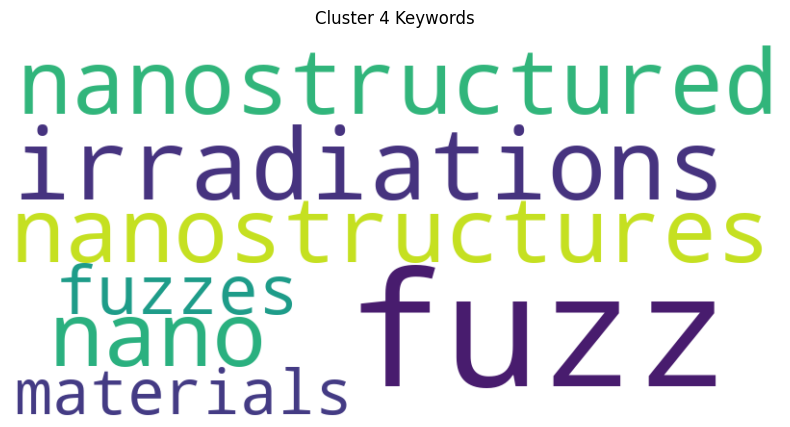

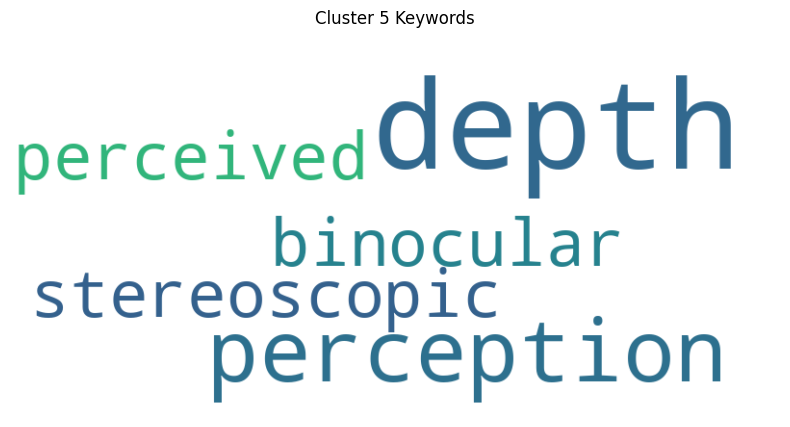

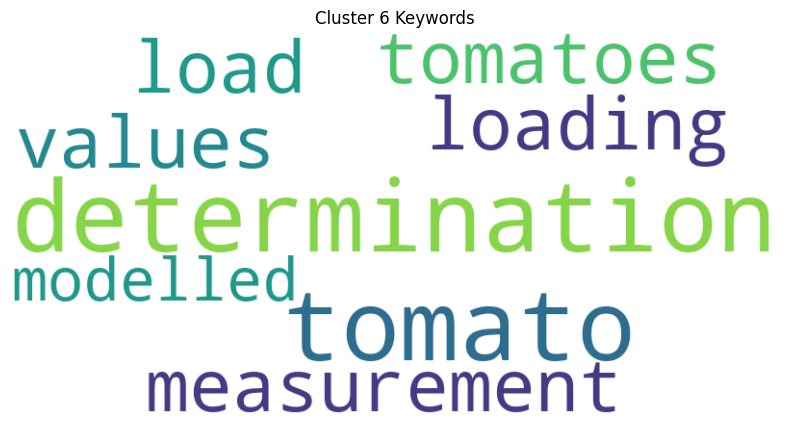

In [ ]:
from keybert import KeyBERT
from wordcloud import WordCloud

# Initialize KeyBERT
kw_model = KeyBERT()

# Extract keywords for each cluster and display word clouds
for cluster_num in range(num_clusters):
    cluster_abstracts = papers[papers['cluster'] == cluster_num]['abstract']
    cluster_text = ' '.join(cluster_abstracts)

    # Extract keywords
    keywords = kw_model.extract_keywords(cluster_text, keyphrase_ngram_range=(1, 2), stop_words='english')
    keyword_list = [kw[0] for kw in keywords]

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keyword_list))

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_num + 1} Keywords')
    plt.axis('off')
    plt.show()
